# DataCrunch Tournament - Master v2.0
## September 8, 2023

This Quickstart notebook will guide you through the design choices and consequential problem statement of the second iteration of the master dataset, released here for the first time.

With the design choices proposed here, we believe we can boost predictive capabilities and, most importantly, align the tournament problem statement with the risk framework used at the portfolio generation level.

## TL;DR

- The number of features has increased from 615 to 857.
- `e-kinetics`, `3b1-signal` and `vratios` strategies have been temporary put on-hold for this version of the master dataset.
- The average cross-section size has increased.
- There are two types of targets: training and scoring targets.
- The *unique* scoring target has returned to uniform quantization.
- [orthogonal-cli](https://pypi.org/project/orthogonal-cli/) release to address the DataCrunch portfolio needs to be orthogonal to their risk model.
- New fitness function proposal, making use of this newly released tool, to train your model with the knowledge of this constraint.

---

# Libraries

In [ ]:
# Install https://pypi.org/project/orthogonal-cli/ 
!pip install orthogonal-cli

In [199]:
import orthogonal 

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import gc
from getpass import getpass
from scipy.stats import spearmanr

---

# Data

As always, we provide three main DataFrames:

- `X_train` contains the features;
- `y_train` contains the train and score targets;
- `X_test` contains the features you can use as an input to your models;

You can either download the data in the *.csv* or *.parquet* extension:

In [200]:
#=============================================================#
#                     DATA AVAILABLE SOON                     #
#=============================================================#

In [ ]:
# Get the features columns
features = [col for col in train_features.columns if 'Feature' in col]

In [139]:
len(features)

857

The first difference we can notice is in the number of features: we added new features. Some old ones have also been updated. We decided to put some strategies on-hold: more work is necessary the get the best out of them. Our aim for the future is to introduce new features dynamically, while deprecating features already in production as little as necessary.

The reference distribution of the features is still Gaussian, with a 7-bins quantization scheme.

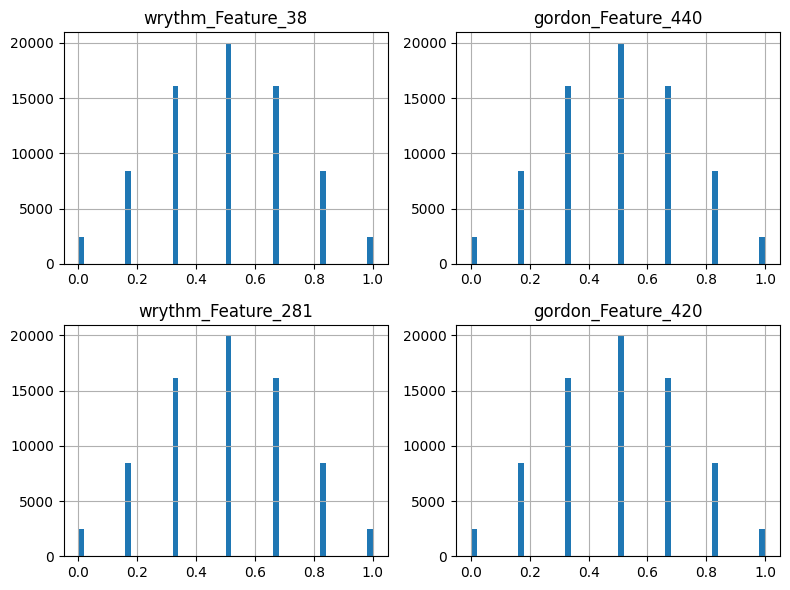

In [140]:
plt_features = random.sample(features, k=4)

fig, axes = plt.subplots(2, 2, figsize=(8, 6))

for idx, pltt in enumerate(plt_features):
    plt.subplot(2, 2, idx + 1)
    plt.hist(train_features[pltt], bins=50)
    plt.title(pltt)
    plt.grid()

plt.tight_layout()
plt.show()

Here is the covariance matrix of the features evaluated on the first few Moons.

In [141]:
cov = train_features.loc[train_features['Moons'] < 5, features].corr()

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cov.abs())

## Universe

In [ ]:
train_features.groupby('Moons').id.count().plot(figsize=(20, 4))
plt.axhline(y = train_features.groupby('Moons').id.count().mean(), color = 'r', linestyle = '-')
plt.grid()

The average cross-section size has increased.

In [144]:
train_features.groupby('Moons').id.count().max()

926

---

## Targets

Let’s take a closer look at the targets:

In [145]:
targets = [col for col in  train_targets.columns if 'target' in col]
targets

['score_target_w',
 'train_target_r',
 'train_target_g',
 'train_target_b',
 'train_target_r_market_industry_neutral',
 'train_target_r_market_neutral',
 'train_target_g_market_neutral',
 'train_target_b_market_neutral',
 'train_target_g_market_industry_neutral',
 'train_target_b_market_industry_neutral',
 'train_target_r_core_industry_neutral',
 'train_target_g_core_industry_neutral',
 'train_target_b_core_industry_neutral']

- Targets are now composed of two families: `train_` and `score_`. 
- The target whose name starts with `score_` will be used to score you.
- The targets whose name starts with `train_` have been designed for training. 
- Our preliminary experimentation shows that you will probably have a better performance on the score target by training on the train targets rather than on the score target itself.

This choice comes from the experimental evidence that, in order to use supervised learning models to predict on a given target, the use of different, less noisy targets (now called `train_target_` to stress this difference) is beneficial. It also appears that the discrimination of signal and noise is a function of the supervised learning design choices. These targets are associated with the core team strongest alphas: we however stress the importance of the unsupervised step of your work, not only in the space of features, but also targets.

### Target Description

Each target is associated with a different time window, identified as before by `_w` (7d), `_r` (30d), `_g` (60d), `_b` (90d), [neutralization](https://www.cambridge.org/core/elements/machine-learning-for-asset-managers/6D9211305EA2E425D33A9F38D0AE3545) and quantization scheme.

Score Target:

- `score_target_w`: uniformly quantized rank of weekly returns.

Train Targets:

- `train_target_r, _g, _b`: t-student-quantized rank of 30, 60, 90 days returns.

- `train_target_r_market_industry_neutral, _b_`: `train_target_r` neutralized against market and industry.

- `train_target_r_core_industry_neutral, _b_`: `train_target_r, _b` neutralized against core risk factors and industry.

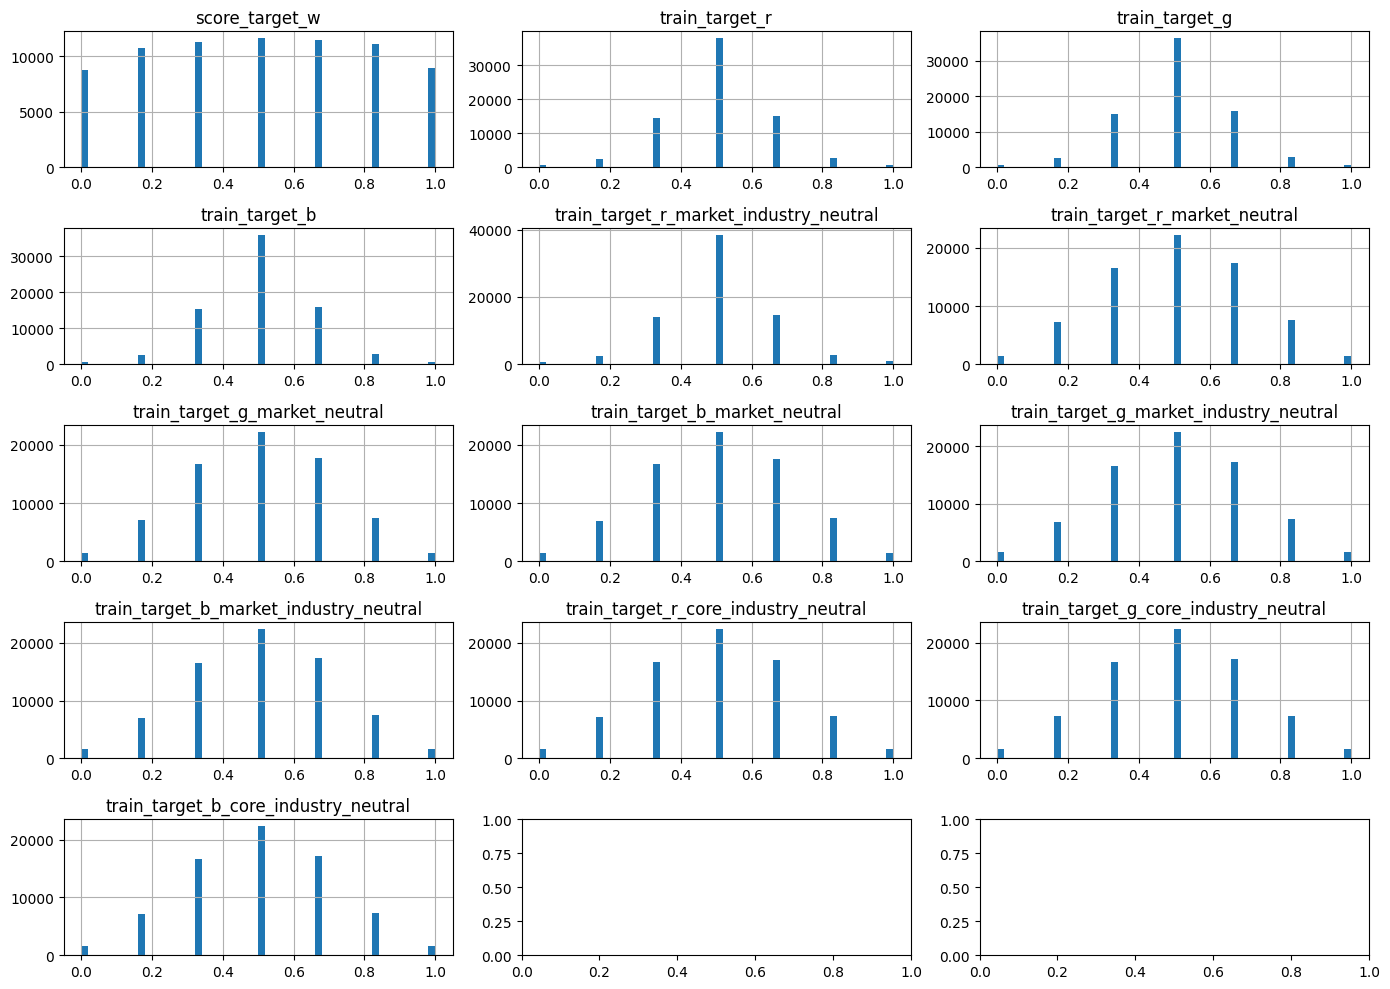

In [146]:
fig, axes = plt.subplots(5, 3, figsize=(14, 10))

for idx, pltt in enumerate(targets):
    plt.subplot(5, 3, idx+1)
    plt.hist(train_targets[pltt], bins=50)
    plt.title(pltt)
    plt.grid()

plt.tight_layout()
plt.show()

In fact, while quantization schemes that reflect the physical metrics associated with labels are still higly helpful in training your models, the rank preserving transformations associated with the processing of features and targets implies that linear Spearman correlation is the most consistent and robust metric for validation and test set evaluation. This design choice has also been inspired by the [ADIA Lab Market Prediction Competition](https://adialab.crunchdao.com/?tab=description) dataset, and the inherent risk of using strongly nonlinear loss functions.

Credits to **@emanuele** and **@worldwide-jeremy** for triggering some of these considerations.

The scoring target is associated with a weekly timeframe, in line with the current round frequency. While your predictive capabilities are stronger on longer timeframe targets, quicker decision-making has the potential to overcompensate this decrease in correlation. This sweet spot (which as of today sits somewhere between 5 and 20 days) can be fine-tuned only with further iterations: today's best estimation is `target_w`.

About scoring target neutralization: we are proposing raw-return-based rankings. Credits to **@scattered-kyle** and to, mainly, **@anxious-james** for valuable insights.

### Notes on Embargo

Each cross-section is associated with a full week. Each target's initial date is associated with a two-days-shift for execution purposes.
Therefore the necessary embargo is:

In [147]:
embargo_w = np.ceil(2/7)
embargo_w

1.0

In [148]:
embargo_r = np.ceil((30 - 7 + 2)/7)
embargo_r

4.0

In [149]:
embargo_g = np.ceil((60 - 7 + 2)/7)
embargo_g

8.0

In [150]:
embargo_b = np.ceil((90 - 7 + 2)/7)
embargo_b

13.0

---

# Orthogonal-CLI

We have built a python package, [orthogonal-cli](https://pypi.org/project/orthogonal-cli/), that enables your models' output to interact with risk dimensions that DataCrunch's fund is interested to hedge, while preserving the confidentiality of these dimensions. Reverse engineering is made impossible by further obfuscating these matrices with non-stationary noise. Nevertheless, the obfuscation scheme, based on [matrix perturbation theory](https://books.google.fr/books/about/Matrix_Perturbation_Theory.html?id=l78PAQAAMAAJ&redir_esc=y), guarantees the translation of the orthogonality condition in the original domain, up to acceptable tolerance.

You can find the source code of the package [here](https://github.com/crunchdao/orthogonal-cli).

# Loss Function

The goal is now to use these risk dimensions to evaluate predictions based on the rank after a partial orthogonalization.

This is important since the features bring valuable information about the state along the risky dimensions; the orthogonalization of targets doesn't necessarily imply that their best predictor, once projected in the space orthogonal to the dimensions of risk, will maintain the same information coefficient.

The derivation provided for clarity in the following subsection, can be skipped for the participation in this bounty.

## Loss Function Derivation

For a given epoch, we assume that the state of each risk vector is represented by the matrix $B$, whose columns we call $\beta_i$, $i=1,\dots,4$. We are interested in evaluating the information coefficient of a standardized prediction vector $\textbf{y}$.

Each prediction can be decomposed as: 
$$
\textbf{y} = \sum_{i=1}^{N} c_i \beta_i + \textbf{y}^o = \textbf{B} \textbf{c} + \textbf{y}^o = \textbf{y}^p  + \textbf{y}^o 
$$
in which the coefficients $c_i$ are determined by a least-square projection, and are therefore not only dependent on the rank of the prediction:

$$
\textbf{c} = (\textbf{B}^T \textbf{B})^{-1}\textbf{B}^T \textbf{y}
$$

and the components of $\textbf{y}^o$ can be therefore interpreted as the residuals of such regression.

Introducing a coefficient $\alpha$, between 0 and 1, we can linearly interpolate the original prediction and the residualized one, to obtain:

$$
\textbf{y}_{score}(\alpha) = \textbf{y} - \alpha \textbf{y}^p
$$

going from no neutralization ($\alpha$ = 0) to full neutralization ($\alpha$ = 1).

With this geometric interpretation in mind, we are interested in partially residualizing predictions and *then* computing their information coefficients. The degree of residualization (i.e., the value of $\alpha$) can be derived, as anticipated, by the following (element-wise) constraint:

$$
|\textbf{B}^T \textbf{y}_{score}(\alpha) | \leq \lambda
$$

$$
\frac{|\textbf{B}^T \textbf{y}_{score}(\alpha) |_i}{\lambda_i}  \leq 1 \, \, \, \forall \, i = 1, ..., N
$$

Let's unpack the equation:

$$ 
\frac{|\textbf{B}^T \textbf{y} - \alpha \textbf{B}^T \textbf{B} (\textbf{B}^T \textbf{B})^{-1} \textbf{B}^T \textbf{y}|_i}{\lambda_i} \leq 1 \, \, \, \forall \, i
$$

$$ 
\frac{|\textbf{B}^T \textbf{y} - \alpha \textbf{B}^T \textbf{y}|_i}{\lambda_i} \leq 1 \, \, \, \forall \, i
$$

$$ 
\frac{(1 - \alpha)|\textbf{B}^T \textbf{y}|_i}{\lambda_i} \leq 1 \, \, \, \forall \, i
$$


$$ 
(1 - \alpha) \leq min\left(\frac{\lambda_i}{|\textbf{B}^T \textbf{y}|_i}\right)
$$

From which the smallest feasible level of orthogonalization is computed using:


$$ 
\alpha = 1 - min\left(\frac{\lambda_i}{|\textbf{B}^T \textbf{y}|_i}\right)
$$

---

# Loss Function Implementation

In order to use the package, please [create an API Key here](https://account.crunchdao.com/account/api) and use it to setup the client:

In [84]:
client = orthogonal.Client(api_key=getpass())

 ········


#### Here is the loss function you will be evaluated against:

In [151]:
def loss(y_pred, y_test, y_pred_col):
    # First, your prediction vector is partially orthogonalized:
    # https://github.com/crunchdao/orthogonal/blob/master/api/service/orthogonalize.py#L27
    y_pred_orth = client.orthogonalize(y_pred, date_column_name='Moons')

    # Secondly, use the orthogonalized prediction to compute a Spearman correlation against the scoring target:
    merged = y_pred_orth.merge(y_test, on=['Moons', 'id'])
    corr = merged.groupby('Moons')[['score_target_w', y_pred_col]].apply(lambda x: x.corr(method='spearman').iloc[0, 1])
    return corr.mean()

## Basic Random Example

In order to interact with the client, let's assume the current test Moon is Moon 100:

In [152]:
synth_test_target = train_targets[train_targets['Moons'] == 100][['id', 'Moons', 'score_target_w']]

In [153]:
y_hat = synth_test_target[['id', 'Moons']].copy()
y_hat['prediction'] = synth_test_target['score_target_w'] + 7*np.random.randn(y_hat.shape[0])

In [154]:
srankcorr = loss(y_hat, synth_test_target, 'prediction')

In [155]:
srankcorr

0.01355741324722977

---

# Example Submission

In this simple example we just split the labeled dataset into one train and validation split. Please follow our [notebooks on GitHub](https://github.com/crunchdao/adialab-notebooks/blob/main/group_timeseries_split.ipynb) on time-aware [cross validation in financial machine learning](https://books.google.fr/books/about/Advances_in_Financial_Machine_Learning.html?id=c75IDwAAQBAJ&redir_esc=y) to get a good estimate of your OOS performance using multiple-folds cross-validation schemes.

In [156]:
from sklearn.linear_model import Ridge
from tqdm import tqdm

In [157]:
# Merge train_features and train_targets for ease of use
train_data = pd.merge(train_features, train_targets, on=['id', 'Moons'], how='inner')

In [158]:
all_moons = train_data.Moons.unique()

In [159]:
train_val_ratio = 0.7
split_moon = int(len(all_moons) * train_val_ratio)

In [160]:
train_features = [c for c in features if 'wrythm' in c] # Features selection placeholder.

In [161]:
selected_train_target = 'train_target_b_market_industry_neutral'
# Think of the choice of the training target and its processing as a specific set of hyperparameter choice. 
# Cross-validation is key here as well.

In [164]:
embargo = int(embargo_b)

In [165]:
train_moons = all_moons[:split_moon]
val_moons = all_moons[split_moon+embargo:] 

In [166]:
# Let's setup a batched estimation scheme.
Xy_train = train_data[train_data['Moons'].isin(train_moons)].iloc[:, 2:]

In [167]:
X_train = Xy_train[train_features]
y_train = Xy_train[selected_train_target] 

In [168]:
Xy_val = train_data[train_data['Moons'].isin(val_moons)]
X_val = Xy_val[train_features]
y_val = Xy_val[['id', 'Moons', 'score_target_w']] 

In [169]:
y_pred_val = y_val[['id', 'Moons']]

In [184]:
alphas = np.logspace(0, 5, 100) # List of alpha values to try

In [185]:
best_loss = -1e10
grid_losses = []
grid_val_train_losses = []

grid_coeff_norms = []

for alpha_i in tqdm(alphas):
    clf = Ridge(alpha=alpha_i)
    clf.fit(X_train, y_train) # Together with the training target, the choice of the training loss function is key here!

    coefficients = clf.coef_
    l2_norm = np.linalg.norm(coefficients)
    grid_coeff_norms.append(l2_norm)
    
    pred_val = clf.predict(X_val)
    y_pred_val['prediction'] = pred_val
    loss_i = loss(y_pred_val, y_val, 'prediction')
    grid_losses.append(loss_i)
    if loss_i > best_loss:
        best_loss = loss_i
        best_alpha = alpha_i

100%|██████████| 100/100 [01:44<00:00,  1.04s/it]


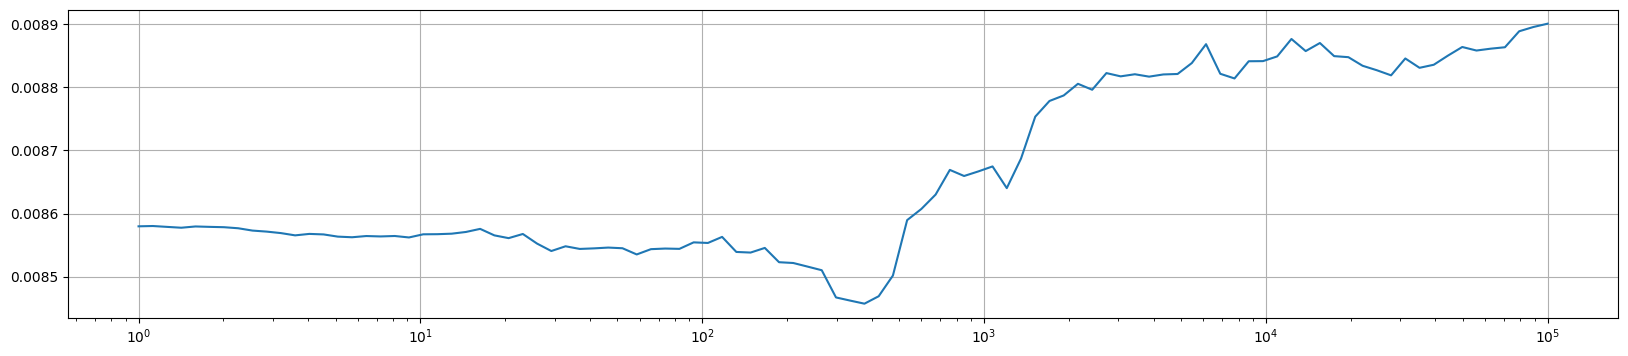

In [186]:
plt.figure(figsize=(20, 4))
plt.semilogx(alphas, grid_losses)
plt.grid()

In [ ]:
plt.figure(figsize=(20, 4))
plt.semilogx(alphas, 

In [ ]:
grid_coeff_norms)
plt.grid()

In [188]:
final_model = Ridge(alpha=best_alpha)
X_final = train_data[features]
y_final = train_data[selected_train_target]

In [ ]:
final_model.fit(X_final, y_final)

In [190]:
X_test = test_features[features]
example_submission = test_features[['id', 'Moons']].copy()

example_submission['y_hat'] = final_model.predict(X_test) 

In [178]:
# Let's run some sanity checks to be sure of the validity of the submission:
def check_columns_name(df):
    if df.columns[:2].tolist() != ['id', 'Moons']:
        raise Exception('Columns name are different from what is expected.')

def check_nans(df):
    if df.isna().sum().sum() > 0:
        raise Exception('NaNs detected')

def check_moons(df):
    if set(df['Moons'].unique()) != set(test_features['Moons'].unique()):
        raise Exception('Moons are different from what is expected')

check_columns_name(example_submission)
check_nans(example_submission)
check_moons(example_submission)
print('Submission: OK')

Submission: OK


In [179]:
# The name of the file is in the format master_v2.parquet
example_submission.to_parquet('master_v2_predictions.parquet') 